## Harmonic Oscillator

$$m\frac{d^2u}{dt^2} + \mu\frac{du}{dt} + k u =0,\quad u(0)=1,\quad \frac{du}{dt}(0) = 0,\quad t\in[0, 1]$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        
def to_tensor(x):
    return torch.tensor(x).float().view(-1, 1).to(device)

def to_array(x):
    return x.view(-1).cpu().detach().numpy()

def gradient(y, x):
    return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
                               create_graph=True, retain_graph=True)[0]

In [7]:
## Equation parameters:
def u_exact(t, d, w0):
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    return 2*A*np.cos(phi + w*t)*np.exp(-d*t)

d, w0 = 2, 20       ## reference value w0 = 20
mu, k = 2*d, w0**2

t_min, t_max = 0, 1
n_pde = 101

## Domain: u_tt + mu * u_t + k * u
t_pde = np.random.rand(n_pde)*(t_max - t_min) + t_min
t_pde = to_tensor(t_pde)

t_ic = to_tensor(0)
u_ic = to_tensor(0)
du_ic = to_tensor(1)

In [ ]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 50),  nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1),
        )

    def forward(self, t):
        return self.net(t)  # (N, 1)
    
    def residual_loss(self, t, mu=mu, k=k):
        t.requires_grad = True
        u = self.forward(t)
        u_t = gradient(u, t)
        u_tt = gradient(u_t, t)
        residual = u_tt + mu * u_t + k * u
        return torch.mean(residual**2)
    
    def ic_du_loss(self, t):
        t.requires_grad = True
        u = self.forward(t)
        u_t = gradient(u, t)    # u'(0) = 0
        return torch.mean((u_t - torch.full_like(t, 0))**2)
    
    def ic_u_loss(self, t):
        u = self.forward(t)     # u(0) = 1
        return torch.mean((u - torch.full_like(t, 1))**2)

In [11]:
## Training
n_epochs = 10000
learning_rate = 1e-3

model = PINN().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.985)

for epoch in range(1, n_epochs + 1):
    model.train()
    loss_pde = model.residual_loss(t_pde)
    loss_ic_du = model.ic_du_loss(t_ic)
    loss_ic_u = model.ic_u_loss(t_ic)

    loss = loss_pde * 1e-4 + loss_ic_du * 1e-2 + loss_ic_u
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % (n_epochs // 10) == 0:
        print(f"[{epoch:5d}/{n_epochs}] (lr: {scheduler.get_last_lr()[0]:.2e}) "
              f"loss: {loss.item():.2e} "
              f"(pde: {loss_pde.item():.2e} ic_du: {loss_ic_du.item():.2e} "
              f"ic_u: {loss_ic_u.item():.2e})")

[ 1000/10000] (lr: 9.85e-04) loss: 3.25e-02 (pde: 3.12e+02 ic_du: 2.32e-04 ic_u: 1.35e-03)
[ 2000/10000] (lr: 9.70e-04) loss: 2.09e-02 (pde: 2.03e+02 ic_du: 1.41e-04 ic_u: 5.43e-04)
[ 3000/10000] (lr: 9.56e-04) loss: 8.35e-03 (pde: 8.28e+01 ic_du: 1.20e-04 ic_u: 6.97e-05)
[ 4000/10000] (lr: 9.41e-04) loss: 7.45e-03 (pde: 7.39e+01 ic_du: 9.53e-05 ic_u: 5.74e-05)
[ 5000/10000] (lr: 9.27e-04) loss: 6.10e-03 (pde: 6.05e+01 ic_du: 6.45e-05 ic_u: 4.48e-05)
[ 6000/10000] (lr: 9.13e-04) loss: 2.11e-03 (pde: 2.10e+01 ic_du: 9.32e-08 ic_u: 1.22e-05)
[ 7000/10000] (lr: 9.00e-04) loss: 8.54e-04 (pde: 8.49e+00 ic_du: 1.42e-04 ic_u: 3.25e-06)
[ 8000/10000] (lr: 8.86e-04) loss: 4.96e-04 (pde: 4.95e+00 ic_du: 5.24e-06 ic_u: 4.40e-07)
[ 9000/10000] (lr: 8.73e-04) loss: 3.14e-04 (pde: 3.13e+00 ic_du: 4.14e-06 ic_u: 3.92e-07)
[10000/10000] (lr: 8.60e-04) loss: 2.16e-04 (pde: 2.16e+00 ic_du: 7.93e-07 ic_u: 4.12e-07)


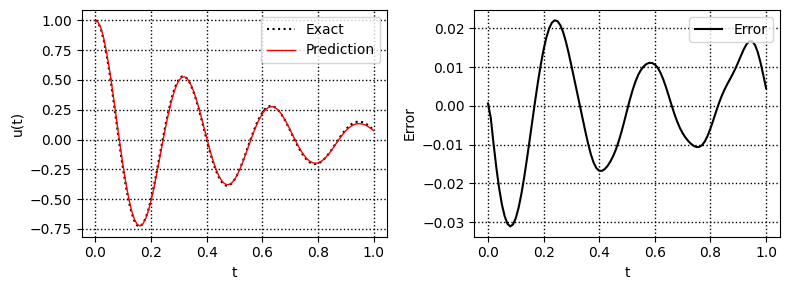

In [17]:
## Evaluation
t_test = np.linspace(0, 1, 101)
with torch.no_grad():
    t = to_tensor(t_test)
    u_pred = model(t)

u_pred = to_array(u_pred).flatten()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3))
ax1.plot(t_test, u_exact(t_test, d, w0), 'k:', label="Exact")
ax1.plot(t_test, u_pred, 'r', lw=1, label="Prediction")
ax1.set(xlabel="t", ylabel="u(t)")

ax2.plot(t_test, u_exact(t_test, d, w0) - u_pred, 'k', label="Error")
ax2.set(xlabel="t", ylabel="Error")

for ax in (ax1, ax2):
    ax.legend(loc="upper right")
    ax.grid(color='k', ls=':', lw=1)
fig.tight_layout()
plt.show()